# Machine learning versus human learning: homology and cross-validation in bioinformatics

This notebook resume the metrics evaluated on different dataset partitions.

## Environment & utils

In [2]:
import numpy as np
import pandas as pd
import json 

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

MATCHING_BRACKETS = [["(", ")"], ["[", "]"], ["{", "}"], ["<", ">"], ["A", "a"], ["B", "a"]] 

def fold2bp(struc, xop="(", xcl=")"):
    openxs = []
    bps = []
    for i, x in enumerate(struc):
        if x == xop: openxs.append(i)
        elif x == xcl: 
            if len(openxs)>0: bps.append([openxs.pop()+1, i+1])
            else: return False
    return bps

def dot2bp(struc):
    bp = []
    for brackets in MATCHING_BRACKETS:
        bp = bp + fold2bp(struc, brackets[0], brackets[1])
    return list(sorted(bp))

def f1_score(ref_bp, pre_bp):
    if len(ref_bp)==0 and len(pre_bp)==0:
        return 1
    tp1 = 0
    for rbp in ref_bp:
        # add tolerance of +/- 1 position
        if rbp in pre_bp or \
            [rbp[0],  rbp[1]-1] in pre_bp or \
            [rbp[0],  rbp[1]+1] in pre_bp or \
            [rbp[0]+1,rbp[1]]   in pre_bp or \
            [rbp[0]-1,rbp[1]]   in pre_bp:
            tp1 = tp1 + 1
    tp2 = 0
    for pbp in pre_bp:
        if pbp in ref_bp or \
            [pbp[0],  pbp[1]-1] in ref_bp or \
            [pbp[0],  pbp[1]+1] in ref_bp or \
            [pbp[0]+1,pbp[1]] in ref_bp or \
            [pbp[0]-1,pbp[1]] in ref_bp:
            tp2 = tp2 + 1
            
    fn = len(ref_bp) - tp1
    fp = len(pre_bp) - tp1
    
    tpr = pre = f1 = 0.0
    if tp1+fn>0: tpr = tp1/float(tp1+fn)     # sensitivity (=recall =power)
    if tp1+fp>0: pre = tp2/float(tp1+fp)     # precision (=ppv)
    if tpr+pre>0: f1 = 2*pre*tpr/(pre+tpr)   # F1 score
    
    return f1

def score(ref, pre):
    ref_bp = dot2bp(ref)
    pre_bp = dot2bp(pre)
    return f1_score(ref_bp, pre_bp)

DATA_PATH = "https://raw.githubusercontent.com/sinc-lab/machine-learning_vs_human-learning/master/"

## Dataset
We use the sequences up to 512 nt of length of [ArchiveII](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7202366/), containing 3865 RNA sequences on 9 very distinctive families.

In [3]:
dataset = pd.read_csv(f"{DATA_PATH}data/archiveII.csv", index_col="id")
dataset

,sequence,structure,base_pairs,len
id,,,,
5s_Acholeplasma-laidlawii-1,UCUGGUGACGAUAGGUAAGAUGGUUCACCUGUUCCCAUCCCGAACA...,((((((((......((((((((....((((((.............)...,"[[1, 111], [2, 110], [3, 109], [4, 108], [5, 1...",112
5s_Acidovorax-temperans-1,UGCCUGAUGACCAUAGCAAGUUGGUACCACUCCUUCCCAUCCCGAA...,.(((((((((.....((((((((.....((((((...............,"[[2, 115], [3, 114], [4, 113], [5, 112], [6, 1...",115
tmRNA_Stre.gord._TRW-29390_1-349,GGGGUCGUUACGGAUUCGACAGGCAUUAUGAGGCAUAUUUUGCGAC...,(((((((............((((((((....(((((((((..((((...,"[[1, 345], [2, 344], [3, 343], [4, 342], [5, 3...",349
tRNA_tdbR00000055-Schizosaccharomyces_pombe-4896-Glu-3UC,UCCGUUGUGGUCCAACGGCUAGGAUUCGUCGCUUUCACCGACGGGA...,(((((((..((((........))))((((((.......)))))).....,"[[1, 71], [2, 70], [3, 69], [4, 68], [5, 67], ...",75
srp_List.mono._U15684,UGGGUUGAUGAGCGUGAAGCCUUCGCUCGGUUGGAUUUUUCUUCAU...,.(.((((...(.(.((.(.((..(.....)..)).)...(...(.....,"[[2, 276], [4, 274], [5, 273], [6, 272], [7, 2...",279
...,...,...,...,...
5s_Bacillus-cereus-6,UGGUAAUGAUGGCAGAGAGGUCACACCCGUUCCCAUACCGAACACG...,((((((.....((((((((.....((((((.............)))...,"[[1, 111], [2, 110], [3, 109], [4, 108], [5, 1...",114
srp_Myco.aviu._AE016958,GGGGACCCCGCGCACCCGACAGAGCCCGUUGACCCUUGCUGCCUUC...,((((.....(.(...(.(.....(.(....).).....).).).)....,"[[1, 53], [2, 52], [3, 51], [4, 50], [10, 45],...",88
tmRNA_Heli.pylo._AE001503_1-383,GGGGCUGACUUGGAUUUCGACAGAUUUCUUGUCGCACAGAUAGCAU...,(((((((.............((((..((((((((.((((((...((...,"[[1, 382], [2, 381], [3, 380], [4, 379], [5, 3...",383


Load the different data partitions

In [4]:
splits = pd.read_csv(f"{DATA_PATH}data/splits.csv")
splits

,Unnamed: 0.1,Unnamed: 0,split_type,fold_name,fold_number,partition,id
0,0,0,k-fold,0,0,train,tmRNA_Stre.gord._TRW-29390_1-349
1,1,1,k-fold,0,0,train,tRNA_tdbR00000055-Schizosaccharomyces_pombe-48...
2,2,2,k-fold,0,0,train,srp_List.mono._U15684
3,3,3,k-fold,0,0,train,srp_Vibr.fisc._CP000020
4,4,4,k-fold,0,0,train,srp_Baci.thur._D11412
...,...,...,...,...,...,...,...
73430,73980,71545,HL90-fold,0,0,train,srp_Fran.tula._CP000608
73431,73981,71546,HL90-fold,0,0,train,tRNA_tdbR00000425-Drosophila_melanogaster-7227...
73432,73982,71547,HL90-fold,0,0,train,tRNA_tdbR00000514-Scenedesmus_obliquus-3088-In...
73433,73983,71548,HL90-fold,0,0,train,5s_Rattus-norvegicus-1


## Predictions

We compared different approaches for structure prediction

- [RNAstructure](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-11-129) 
- [IPknot](https://github.com/satoken/ipknot)
- [Linear-fold](https://github.com/LinearFold/LinearFold)
- [dl-RNA](https://github.com/marcellszi/dl-rna)
- [UFold](https://github.com/uci-cbcl/UFold)

In [5]:
summary = []
for method in ["RNAstructure", "IPknot", "Linear-fold", "dl-rna", "UFold"]:
    print(method, end=" ")
    pred = pd.read_csv(f"{DATA_PATH}results/{method}.csv", index_col="id")
    pred["ref"] = dataset.loc[pred.index]["structure"]
    
    if method in ["dl-rna", "UFold"]:
        pred["F1"] = pred.apply(lambda x: f1_score(dot2bp(x["ref"]), json.loads(x["folding"])), axis=1)
    else:
        pred["F1"] = pred.apply(lambda x: f1_score(dot2bp(x["ref"]), dot2bp(x["folding"])), axis=1)
    
    
    pred["method"] = method
    for split_type in splits.split_type.unique():
        test_ids = splits[(splits.split_type==split_type) & (splits.partition=="test")].id
        if method not in ["dl-rna", "UFold"]: 
            pred["split-type"] = split_type 
            summary.append(pred.loc[test_ids].drop(columns=["folding", "ref"]))
        else:
            summary.append(pred[pred["split-type"]==split_type].loc[test_ids].drop(columns=["folding", "ref"]))
            
    print("✓")
    
summary = pd.concat(summary)


RNAstructure ✓
IPknot ✓
Linear-fold ✓
dl-rna ✓
UFold ✓


## Structure similarity across folds

In [6]:
similarities = pd.read_csv(f"{DATA_PATH}data/structure_avg_similarities.csv")
similarities

,Unnamed: 0,split-type,sim
0,0,k-fold,0.915635
1,1,fam-fold,0.359985
2,2,hl10-fold,0.771091
3,3,hl25-fold,0.861455
4,4,hl50-fold,0.907747
5,5,hl75-fold,0.947475
6,6,hl90-fold,0.965032


# Plot

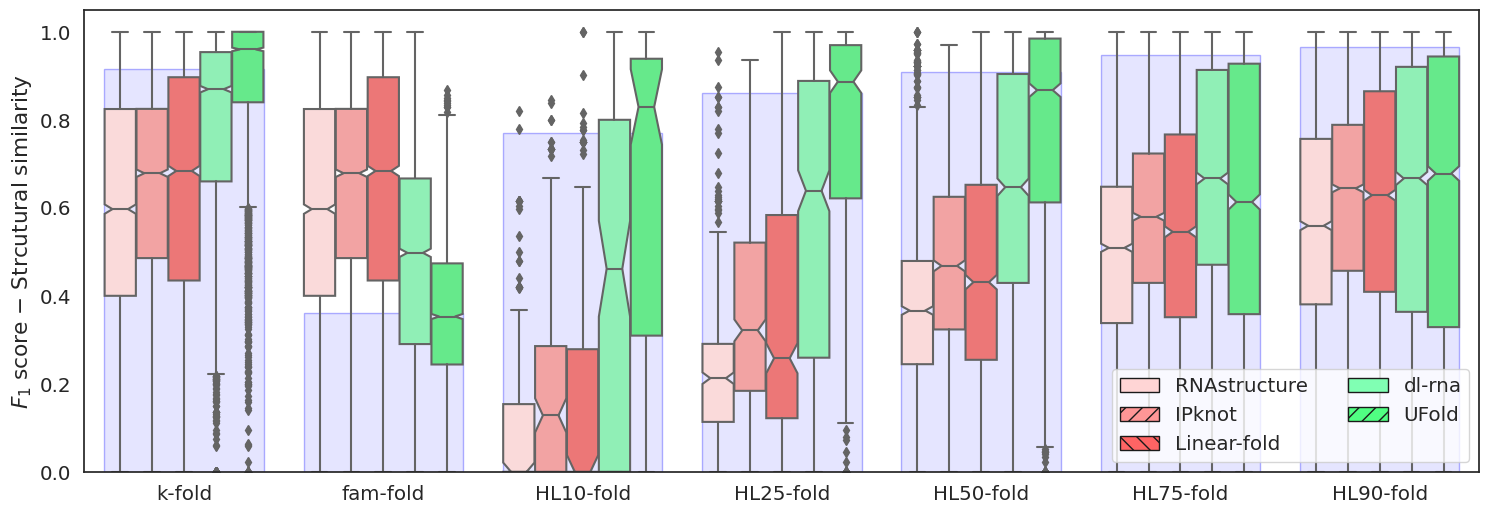

In [7]:
sns.set(rc={'figure.figsize':(18,6)})
sns.set(font_scale=1.3)
sns.set_style(style='white') 

col = [np.array([255,213,213])/255, 
       np.array([255,150,150])/255, 
       np.array([255,100,100])/255, 
       np.array([128,255,179])/255, 
       np.array([ 80,255,130])/255]
lbs = ["RNAstructure", "IPknot", "Linear-fold", "dl-rna", "UFold"]
pal = {}
for i, ll in enumerate(lbs): pal[ll] = col[i]

bp = sns.barplot(data=similarities, x="split-type", y="sim", 
                 facecolor=(0.0,0.0,1.0,0.1), linewidth=1, 
                 edgecolor=(0.0,0.0,1.0,0.3), zorder=-1)
vp = sns.boxplot(data=summary, x="split-type", y="F1", hue="method", 
                 palette=pal, notch=True, zorder=1)
vp.set_ylabel("$F_1$ score $-$ Strcutural similarity")
vp.set_xlabel("")

hts = ["", "//", "\\\\", "", "//"]*7
for hatch, patch in zip(hts, vp.artists): patch.set_hatch(hatch)

hdls = []
for i, ll in enumerate(lbs): 
  hdls.append(mpatches.Patch(facecolor=col[i], edgecolor="k", 
                             hatch=hts[i], label=ll))
vp.legend(loc='lower right', handles=hdls, ncol=2);

plt.savefig('hl_vs_ml_boxplot4.pdf', bbox_inches='tight', transparent=True)